In [1]:
!pip install opendatasets
!pip install sentencepiece"
!pip install --upgrade pip
!pip3.10 install seqeval
!pip install transformers
!pip install tqdm
!pip install datasets
!pip install transformers[torch]
!pip install accelerate -U


/bin/bash: -c: line 1: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 2: syntax error: unexpected end of file
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 836.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=5705646612506a9a358225e6a66bbb1cafafb6cbb2faa8bfde8d695df249804e
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:0

In [2]:
# download the datasets

import os
import opendatasets as od
import pandas as pd
import json

data_path = "./pii-detection-removal-from-educational-data/"

# download the data from kaggle
if not os.path.exists(data_path):
    print("Dataset not found, downloading from Kaggle")
    dataset = "https://www.kaggle.com/competitions/pii-detection-removal-from-educational-data/data"
    od.download(dataset)
else:
    print("Dataset found in disk")

# check for the files present there
assert os.path.exists(data_path + "train.json"), "train.json file missing"
assert os.path.exists(data_path + "test.json"), "test.json file missing"


train_df = pd.read_json(open(data_path + "train.json"))
print("train_df loaded")

test_df = pd.read_json(open(data_path + "test.json"))
print("test_df loaded")

Dataset not found, downloading from Kaggle
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aditya2901
Your Kaggle Key: ··········


100%|██████████| 21.4M/21.4M [00:00<00:00, 78.3MB/s]



Extracting archive ./pii-detection-removal-from-educational-data/pii-detection-removal-from-educational-data.zip to ./pii-detection-removal-from-educational-data
train_df loaded
test_df loaded


In [3]:
from tqdm import tqdm
import numpy as np

data = json.load(open(data_path + "train.json"))
pos = []
neg = []

for d in tqdm(data):
    if any(np.array(d["labels"]) != "O"):
        pos.append(d)
    else:
        neg.append(d)

print("total datapoints : ", len(data))
print("positive examples : ", len(pos))
print("negative examples : ", len(neg))



100%|██████████| 6807/6807 [00:01<00:00, 6720.54it/s]

total datapoints :  6807
positive examples :  945
negative examples :  5862


In [4]:
from itertools import chain


labels = sorted(list(set(chain(*[x["labels"] for x in data]))))
label_to_id = {l: i for i,l in enumerate(labels)}
id_to_label = {v:k for k,v in label_to_id.items()}

target = [
    'B-EMAIL', 'B-ID_NUM', 'B-NAME_STUDENT', 'B-PHONE_NUM',
    'B-STREET_ADDRESS', 'B-URL_PERSONAL', 'B-USERNAME', 'I-ID_NUM',
    'I-NAME_STUDENT', 'I-PHONE_NUM', 'I-STREET_ADDRESS', 'I-URL_PERSONAL'
]

print(id_to_label)

{0: 'B-EMAIL', 1: 'B-ID_NUM', 2: 'B-NAME_STUDENT', 3: 'B-PHONE_NUM', 4: 'B-STREET_ADDRESS', 5: 'B-URL_PERSONAL', 6: 'B-USERNAME', 7: 'I-ID_NUM', 8: 'I-NAME_STUDENT', 9: 'I-PHONE_NUM', 10: 'I-STREET_ADDRESS', 11: 'I-URL_PERSONAL', 12: 'O'}


In [5]:
def tokenize(example, tokenizer, label2id, max_length):

    # rebuild text from tokens
    text = []
    labels = []

    for t, l, ws in zip(
        example["tokens"], example["provided_labels"], example["trailing_whitespace"]
    ):
        text.append(t)
        labels.extend([l] * len(t))

        if ws:
            text.append(" ")
            labels.append("O")

    # actual tokenization
    tokenized = tokenizer("".join(text), return_offsets_mapping=True, max_length=max_length)

    labels = np.array(labels)

    text = "".join(text)
    token_labels = []

    for start_idx, end_idx in tokenized.offset_mapping:
        # CLS token
        if start_idx == 0 and end_idx == 0:
            token_labels.append(label2id["O"])
            continue

        # case when token starts with whitespace
        if text[start_idx].isspace():
            start_idx += 1

        token_labels.append(label2id[labels[start_idx]])

    length = len(tokenized.input_ids)

    return {**tokenized, "labels": token_labels, "length": length}

In [6]:
from transformers import AutoTokenizer
from datasets import Dataset, features

TRAINING_MODEL_PATH = "microsoft/deberta-v3-base"
TRAINING_MAX_LENGTH = 1024
OUTPUT_DIR = "output"

tokenizer = AutoTokenizer.from_pretrained(TRAINING_MODEL_PATH)

ds = Dataset.from_dict({
    "full_text": [x["full_text"] for x in data],
    "document": [str(x["document"]) for x in data],
    "tokens": [x["tokens"] for x in data],
    "trailing_whitespace": [x["trailing_whitespace"] for x in data],
    "provided_labels": [x["labels"] for x in data],
})
ds = ds.map(tokenize, fn_kwargs={"tokenizer": tokenizer, "label2id": label_to_id, "max_length": TRAINING_MAX_LENGTH}, num_proc=3)
# ds = ds.class_encode_column("group")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map (num_proc=3):   0%|          | 0/6807 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

In [7]:
x = ds[0]

for t,l in zip(x["tokens"], x["provided_labels"]):
    if l != "O":
        print((t,l))

print("*"*100)

for t, l in zip(tokenizer.convert_ids_to_tokens(x["input_ids"]), x["labels"]):
    if id_to_label[l] != "O":
        print((t,id_to_label[l]))

('Nathalie', 'B-NAME_STUDENT')
('Sylla', 'I-NAME_STUDENT')
('Nathalie', 'B-NAME_STUDENT')
('Sylla', 'I-NAME_STUDENT')
('Nathalie', 'B-NAME_STUDENT')
('Sylla', 'I-NAME_STUDENT')
****************************************************************************************************
('N', 'B-NAME_STUDENT')
('atha', 'B-NAME_STUDENT')
('lie', 'B-NAME_STUDENT')
('▁S', 'I-NAME_STUDENT')
('ylla', 'I-NAME_STUDENT')
('N', 'B-NAME_STUDENT')
('atha', 'B-NAME_STUDENT')
('lie', 'B-NAME_STUDENT')
('▁S', 'I-NAME_STUDENT')
('ylla', 'I-NAME_STUDENT')
('N', 'B-NAME_STUDENT')
('atha', 'B-NAME_STUDENT')
('lie', 'B-NAME_STUDENT')
('▁S', 'I-NAME_STUDENT')
('ylla', 'I-NAME_STUDENT')


In [8]:
from seqeval.metrics import recall_score, precision_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score

def compute_metrics(p, all_labels):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [all_labels[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [all_labels[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    recall = recall_score(true_labels, true_predictions)
    precision = precision_score(true_labels, true_predictions)
    f1_score = (1 + 5*5) * recall * precision / (5*5*precision + recall)

    results = {
        'recall': recall,
        'precision': precision,
        'f1': f1_score
    }
    return results

In [9]:
from transformers import AutoModelForTokenClassification, DataCollatorForTokenClassification, TrainingArguments, Trainer
from functools import partial

model = AutoModelForTokenClassification.from_pretrained(
    TRAINING_MODEL_PATH,
    num_labels=len(labels),
    id2label=id_to_label,
    label2id=label_to_id,
    ignore_mismatched_sizes=True
)
collator = DataCollatorForTokenClassification(tokenizer, pad_to_multiple_of=16)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# I actually chose to not use any validation set. This is only for the model I use for submission.
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    fp16=True,
    learning_rate=2e-5,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    report_to="none",
    evaluation_strategy="no",
    do_eval=False,
    save_total_limit=1,
    logging_steps=20,
    lr_scheduler_type='cosine',
    metric_for_best_model="f1",
    greater_is_better=True,
    warmup_ratio=0.1,
    weight_decay=0.01
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds,
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=partial(compute_metrics, all_labels=labels),
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [11]:
%%time
trainer.train()

Step,Training Loss
20,2.858000
40,2.339600
60,0.891300
80,0.091700
100,0.010800
120,0.008000
140,0.015400
160,0.011700
180,0.013500
200,0.010500


CPU times: user 18min 54s, sys: 2min 57s, total: 21min 52s
Wall time: 24min 9s


TrainOutput(global_step=2553, training_loss=0.050269051930244064, metrics={'train_runtime': 1448.976, 'train_samples_per_second': 14.093, 'train_steps_per_second': 1.762, 'total_flos': 9485443697980512.0, 'train_loss': 0.050269051930244064, 'epoch': 3.0})

In [12]:
trainer.save_model("deberta3base_1024")
tokenizer.save_pretrained("deberta3base_1024")

('deberta3base_1024/tokenizer_config.json',
 'deberta3base_1024/special_tokens_map.json',
 'deberta3base_1024/spm.model',
 'deberta3base_1024/added_tokens.json',
 'deberta3base_1024/tokenizer.json')

In [13]:
 !zip -r deberta3base_1024.zip deberta3base_1024/

  adding: deberta3base_1024/ (stored 0%)
  adding: deberta3base_1024/tokenizer.json (deflated 77%)
  adding: deberta3base_1024/spm.model (deflated 50%)
  adding: deberta3base_1024/config.json (deflated 58%)
  adding: deberta3base_1024/added_tokens.json (stored 0%)
  adding: deberta3base_1024/training_args.bin (deflated 51%)
  adding: deberta3base_1024/tokenizer_config.json (deflated 73%)
  adding: deberta3base_1024/special_tokens_map.json (deflated 50%)
  adding: deberta3base_1024/model.safetensors (deflated 17%)


# Playground

In [100]:
# download the datasets

import os
import opendatasets as od
import pandas as pd
import json

data_path = "./pii-detection-removal-from-educational-data/"

# download the data from kaggle
if not os.path.exists(data_path):
    print("Dataset not found, downloading from Kaggle")
    dataset = "https://www.kaggle.com/competitions/pii-detection-removal-from-educational-data/data"
    od.download(dataset)
else:
    print("Dataset found in disk")

# check for the files present there
assert os.path.exists(data_path + "train.json"), "train.json file missing"
assert os.path.exists(data_path + "test.json"), "test.json file missing"


train_df = pd.read_json(open(data_path + "train.json"))
print("train_df loaded")

test_df = pd.read_json(open(data_path + "test.json"))
print("test_df loaded")

Dataset found in disk
train_df loaded
test_df loaded


In [101]:
from tqdm import tqdm
import numpy as np

data = json.load(open(data_path + "train.json"))
pos = []
neg = []

for d in tqdm(data):
    if any(np.array(d["labels"]) != "O"):
        pos.append(d)
    else:
        neg.append(d)

print("total datapoints : ", len(data))
print("positive examples : ", len(pos))
print("negative examples : ", len(neg))



100%|██████████| 6807/6807 [00:00<00:00, 14650.96it/s]

total datapoints :  6807
positive examples :  945
negative examples :  5862


In [102]:
from itertools import chain


labels = sorted(list(set(chain(*[x["labels"] for x in data]))))
label_to_id = {l: i for i,l in enumerate(labels)}
id_to_label = {v:k for k,v in label_to_id.items()}

target = [
    'B-EMAIL', 'B-ID_NUM', 'B-NAME_STUDENT', 'B-PHONE_NUM',
    'B-STREET_ADDRESS', 'B-URL_PERSONAL', 'B-USERNAME', 'I-ID_NUM',
    'I-NAME_STUDENT', 'I-PHONE_NUM', 'I-STREET_ADDRESS', 'I-URL_PERSONAL'
]

print(id_to_label)

{0: 'B-EMAIL', 1: 'B-ID_NUM', 2: 'B-NAME_STUDENT', 3: 'B-PHONE_NUM', 4: 'B-STREET_ADDRESS', 5: 'B-URL_PERSONAL', 6: 'B-USERNAME', 7: 'I-ID_NUM', 8: 'I-NAME_STUDENT', 9: 'I-PHONE_NUM', 10: 'I-STREET_ADDRESS', 11: 'I-URL_PERSONAL', 12: 'O'}


In [103]:
def tokenize(example, tokenizer, label2id, max_length):

    # rebuild text from tokens
    text = []
    labels = []

    for t, l, ws in zip(
        example["tokens"], example["provided_labels"], example["trailing_whitespace"]
    ):
        text.append(t)
        labels.extend([l] * len(t))

        if ws:
            text.append(" ")
            labels.append("O")

    # actual tokenization
    tokenized = tokenizer("".join(text), return_offsets_mapping=True, max_length=max_length)

    labels = np.array(labels)

    text = "".join(text)
    token_labels = []

    for start_idx, end_idx in tokenized.offset_mapping:
        # CLS token
        if start_idx == 0 and end_idx == 0:
            token_labels.append(label2id["O"])
            continue

        # case when token starts with whitespace
        if text[start_idx].isspace():
            start_idx += 1

        token_labels.append(label2id[labels[start_idx]])

    length = len(tokenized.input_ids)

    return {**tokenized, "labels": token_labels, "length": length}

In [104]:
from transformers import AutoTokenizer
from datasets import Dataset, features

TRAINING_MODEL_PATH = "microsoft/deberta-v3-base"
TRAINING_MAX_LENGTH = 1024
OUTPUT_DIR = "output"

tokenizer = AutoTokenizer.from_pretrained(TRAINING_MODEL_PATH)

ds = Dataset.from_dict({
    "full_text": [x["full_text"] for x in data],
    "document": [str(x["document"]) for x in data],
    "tokens": [x["tokens"] for x in data],
    "trailing_whitespace": [x["trailing_whitespace"] for x in data],
    "provided_labels": [x["labels"] for x in data],
})

print(ds)
# ds = ds.map(tokenize, fn_kwargs={"tokenizer": tokenizer, "label2id": label_to_id, "max_length": TRAINING_MAX_LENGTH}, num_proc=3)
# ds = ds.class_encode_column("group")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Dataset({
    features: ['full_text', 'document', 'tokens', 'trailing_whitespace', 'provided_labels'],
    num_rows: 6807
})


In [105]:
train_df = pd.read_json(open(data_path + "train.json"))
train_df["document"].max()

22687

# metric evaluator

In [123]:
pred_df = pd.read_csv("sample_pred.csv")
display(pred_df.head())

print("total len of pred_df : ", len(pred_df))

,document,token,label,token_str,row_id
0,7,9,B-NAME_STUDENT,Nathalie,0
1,7,10,I-NAME_STUDENT,Sylla,1
2,7,482,B-NAME_STUDENT,Nathalie,2
3,7,483,I-NAME_STUDENT,Sylla,3
4,7,741,B-NAME_STUDENT,Nathalie,4


total len of pred_df :  3232


### get the actuals from train data

In [124]:
# create a copy
train_df_clean = train_df.copy()

def create_token_list(token_list):
  return list(range(len(token_list)))  # Create list based on current list length

train_df_clean["token"] = train_df_clean["tokens"].apply(create_token_list)

# explode the columns "tokens" and "labels"
train_df_clean = train_df_clean.explode(["tokens", "labels", "token"], ignore_index=True)

# drop the unnecessary columns
train_df_clean.drop(columns=["full_text", "trailing_whitespace"], inplace=True)

# rename the columns
train_df_clean.rename(columns={"tokens" : "token_str", "labels" : "label"}, inplace=True)

# create a new column "token"
# train_df_clean["token"] = train_df_clean.index

# filter the rows based on label
train_df_clean = train_df_clean[train_df_clean["label"] != "O"]

# reset the index again
train_df_clean.reset_index(drop=True, inplace=True)

# create a column "row_id"
train_df_clean["row_id"] = train_df_clean.index

train_df_clean.head()

print("total len of train_df_cleaned : ", len(train_df_clean))
print("Total NA : ")
print(train_df_clean.isna().sum())

total len of train_df_cleaned :  2739
Total NA : 
document     0
token_str    0
label        0
token        0
row_id       0
dtype: int64


## compare the values and get the score

In [125]:
pred_df_copy = pred_df.drop(columns=["row_id", "token_str"])
train_df_clean_copy = train_df_clean.drop(columns=["row_id", "token_str"])

comb_df = pd.merge(pred_df_copy, train_df_clean_copy, how="outer", suffixes=("","_pred"), on=["token", "document"])
print("total len of comb_df : ", len(comb_df))
display(comb_df.isna().sum())

comb_df.fillna("O", inplace=True)

display(comb_df.isna().sum())


total len of comb_df :  3337


document        0
token           0
label         105
label_pred    583
dtype: int64

document      0
token         0
label         0
label_pred    0
dtype: int64

In [128]:
comb_df

,document,token,label,label_pred
0,10,0,B-NAME_STUDENT,B-NAME_STUDENT
1,93,0,B-NAME_STUDENT,B-NAME_STUDENT
2,166,0,B-NAME_STUDENT,B-NAME_STUDENT
3,288,0,B-NAME_STUDENT,B-NAME_STUDENT
4,308,0,B-NAME_STUDENT,B-NAME_STUDENT
...,...,...,...,...
3332,7745,2460,O,I-NAME_STUDENT
3333,7745,2462,O,B-NAME_STUDENT
3334,7745,2463,O,I-NAME_STUDENT
3335,12888,3288,B-NAME_STUDENT,B-NAME_STUDENT


['B-EMAIL' 'B-ID_NUM' 'B-NAME_STUDENT' 'B-PHONE_NUM' 'B-STREET_ADDRESS'
 'B-URL_PERSONAL' 'B-USERNAME' 'I-ID_NUM' 'I-NAME_STUDENT' 'I-PHONE_NUM'
 'I-STREET_ADDRESS' 'I-URL_PERSONAL' 'O']


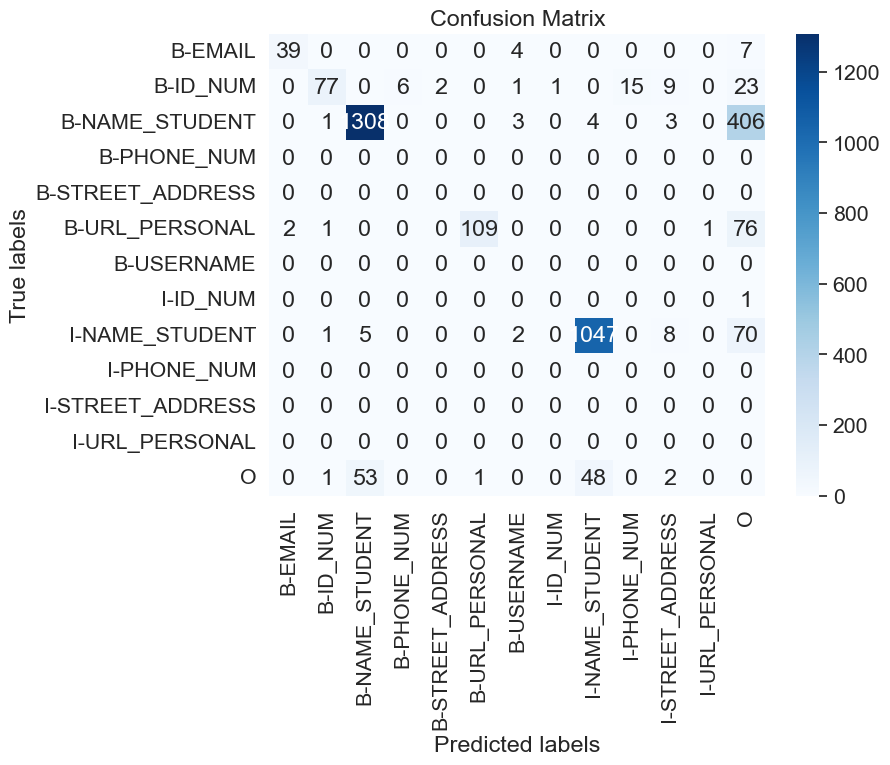

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = comb_df["label"]
y_pred = comb_df["label_pred"]

labels = np.unique(np.concatenate((y_true, y_pred)))
print(labels)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [138]:
from sklearn.metrics import fbeta_score

score = fbeta_score(y_true, y_pred, beta=5, average="weighted")
print("F Beta Score : ", score)

F Beta Score :  0.777646522789202


In [144]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

f1_score = f1_score(y_true, y_pred, average="weighted")
print("F1 Score : ", score)

acc_score = accuracy_score(y_true, y_pred)
print("Accuracy Score : ", acc_score)

prec_score = precision_score(y_true, y_pred, average="weighted")
print("Precision Score : ", prec_score)

recall_score = recall_score(y_true, y_pred, average="weighted")
print("Recall Score : ", recall_score)

F1 Score :  0.777646522789202
Accuracy Score :  0.773149535510938
Precision Score :  0.9269924271019276
Recall Score :  0.773149535510938


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [145]:
train_df.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."
